# Adding small communities to de Boer (2000)

Having recreated and validated found results of de Boer (2000) together with a less ad hoc variant of the Bark Operator we shift our focus on extending de Boer (2000).
As we discuss in the report, this extension is in changing the interaction network of the agents.
Instead of randomly picking a speaker and and imitator, we use a selection strategy based on a small community.
We have different roles in this small community, which each have their own characteristic properties and custom influences from other agents.


**References**

de Boer, B. (2000). Self-organization in vowel systems. *In Journal of Phonetics (Vol. 28, Issue 4, pp. 441–465)*. Elsevier BV. https://doi.org/10.1006/jpho.2000.0125


<hr>
<hr>

## Table of contents

- Student information
- Required imports
- Adding an extra CommunityRole enum and CommunityBehaviour class
- Extending the agent class
- Creating custom game state
- Creating custom game engine
- Playing sample games
- Adding more statistics

<hr>
<hr>

## Student information

- **Name**: Bontinck Lennert
- **Student ID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

<hr>
<hr>

## Required imports

Below we import the required things for this notebook.

In [1]:
# Import imitation game classes made in the previous notebook
from imitationGameClasses import Agent, Synthesizer, BarkOperator, Sound, Utterance, Statistics;

# Used for easier numerical operations
import random as rnd;

# Enum for role
from enum import Enum;

# Deep copy lists
import copy;

# Used for saving and loading variables
import pickle;

# Used for plotting
import matplotlib.pyplot as plt;

<hr>
<hr>

## Adding an extra CommunityRole enum and CommunityBehaviour class

In order to represent the role of the community member (agent), we make a simple enum type.
The idea is as follows, imagine that the `category_age_width` is 20

- There are 7 babies, each of these have 1 parent and 1 grandparent. 
   - This parent is either a regular parent or a doctorate, respectively this grandparent is either a regular grandparent or a professor
   - after 10 years (`category_age_width` / 2) the babies become students
   - after 10 more years (20 since baby), the students become parents or doctorates, depending on their own parent
- There are 5 parents who lost their grandparent but still have a parent
- There are 5 grandparents
- There are 2 doctorates who lost their grandparent but still have a parent (a professor)
- There are 2 professors
- In total we have in total: 7 + 5 + 2 + 5 + 2 = 7 * 3 = 21 agents in this configuration



In [2]:
class CommunityRole(Enum):
    """This is an enum used to represent the agent's community role."""
    PROFESSOR = 1;
    DOCTORATE = 2;
    STUDENT = 3;
    BABY = 4;
    PARENT = 5;
    GRANDPARENT = 6;
    # Added to depict communication with true parent/grandparent
    MYPARENT = 7;
    MYGRANDPARENT = 8;

To represent the influence and other community based parameters for an agent we add a CommunityBehaviour class.

In [3]:
class CommunityBehaviour():
    """This is a class used to represent the innfluence and other community based parameters for an agent."""
    def __init__(self, new_sound_prob: float, phoneme_step_size: float, influence_dictionary: float,
                 synthesizer: Synthesizer, influential_agent_types: list):
        """Creates a CommunityBehaviour instance."""
        # Chance of adding new random vowel
        self.new_sound_prob = new_sound_prob;
        
        # Step size
        self.phoneme_step_size = phoneme_step_size;

        # Influence of specific roles (more influence = better attempt at recreating heard sound)
        self.influence_dictionary = influence_dictionary
        
        # Allows for custom noise
        self.synthesizer = synthesizer;
        
        # Types of agents that the agent wants to interact with
        self.influential_agent_types = influential_agent_types;

<hr>
<hr>

## Extending the agent class

We now extend the existing agent class recreated from de Boer (2000) to implement some extra logic needed for playing immitation games.
In essence we need:
   - A way of controlling the amount of steps taken towards the heard sound based on the oponents role
   - A way to evolve an agent to a new role with a different behaviour
   - A check if we want to optimised depending on the agents community behaviour
      - e.g. professor doesn't listen to a baby



In [4]:
# Defining child class so that Agent methods are copied
class CommunityAgent(Agent):
    """This is an extension of the agent class so that the agent represents
    an agent in the described community setting."""
    # Constructor
    def __init__(self, synthesizer: Synthesizer, bark_operator: BarkOperator,
                    community_role : CommunityRole, community_behaviour: CommunityBehaviour,
                    logger: bool = False,
                    phoneme_step_size: float = 0.1, max_similar_sound_loops: int = 20, max_semi_random_loop: int = 5,
                    sound_threshold_game: float = 0.5, sound_threshold_agent:float = 0.7, sound_minimum_tries: int = 5,
                    cleanup_prob = 0.1, new_sound_prob = 0.01, merge_prob = 1      
                ):
        
        # Use init of Agent
        Agent.__init__(self, synthesizer = synthesizer, bark_operator = bark_operator,
                       logger = logger, phoneme_step_size = phoneme_step_size,
                       max_similar_sound_loops = max_similar_sound_loops,
                       max_semi_random_loop = max_semi_random_loop, sound_threshold_game = sound_threshold_game,
                       sound_threshold_agent = sound_threshold_agent, sound_minimum_tries = sound_minimum_tries,
                       cleanup_prob = cleanup_prob, new_sound_prob = new_sound_prob,
                       merge_prob = merge_prob);
        
        # Store community role
        self.community_role = community_role;
        
        # Store community behaviour
        self.community_behaviour = community_behaviour;
        
    # Prepare for the current game
    def prepare_current_game(self, oponent_role: CommunityRole):
        """Prepare parameters to reflect oponent of current game."""
        # Save role of oponent for game
        self.oponent_role = oponent_role;
        
    # Prepare for the current game
    def change_agent_role_and_behaviour(self, new_role: CommunityRole, new_behaviour: CommunityBehaviour):
        """Update an agent to a new agent"""
        # Store community role
        self.community_role = new_role;
        
        # Store community behaviour
        self.community_behaviour = new_behaviour;
        
        # Update synthesizer
        self.synthesizer = new_behaviour.synthesizer;
        
        # Update step size
        self.phoneme_step_size = new_behaviour.phoneme_step_size;
        
        if self.logger:
            print(f"{self.name}: update my role and behaviour to reflect {new_role.name}.");

        
    # Edit so that we perform multiple loops based on influence
    def improve_sound(self, original_sound: Sound, goal_utterance: Utterance):
        """Returns improved original sound which is more like the goal sound.
        Considers all permutations of phoneme using phoneme_step_size.
        Loops multiple times corresponding to oponent's influence"""
        
        # improved sound is original sound initially
        improved_sound = original_sound;
        
        for _ in range(self.community_behaviour.influence_dictionary[self.oponent_role]):
            improved_sound = super().improve_sound(improved_sound, goal_utterance);

        return improved_sound;

    # Edit so that we only change our vowel repetoire if we "care about" the oponent
    def process_non_verbal_imitation_confirmation(self, was_success):
        """Processes the non verbal confirmation if an imitation was correct, ending the game cycle.
        Agent only adopts if the oponent's role was an influencing one."""
        if was_success:
            # Save success
            self.known_sounds[self.last_spoken_sound].was_success();
            # "Shift closer" if we care about oponent agent
            if self.oponent_role in self.community_behaviour.influential_agent_types:
                improved_sound = self.improve_sound(self.known_sounds[self.last_spoken_sound], self.last_heard_utterance);
                self.known_sounds[self.last_spoken_sound].improve(improved_sound);
        else:
            if self.known_sounds[self.last_spoken_sound].success_ratio() < self.sound_threshold_game:
                # Probably bad sound - "Shift closer" and we care about oponent
                if self.oponent_role in self.community_behaviour.influential_agent_types:
                    improved_sound = self.improve_sound(self.known_sounds[self.last_spoken_sound], self.last_heard_utterance);
                    self.known_sounds[self.last_spoken_sound].improve(improved_sound);
            else:
                # Probably good sound - add new sound to repetoire if we care about oponent
                if self.oponent_role in self.community_behaviour.influential_agent_types:
                    self.add_similar_sound(self.last_heard_utterance);


        if self.logger:
            if was_success:
                print(self.name + ": had a confirmed match, changed my sound to match closer.");

        # End of current game
        self.prepare_for_new_game(was_imitator=True, was_succes= was_success);


<hr>
<hr>

## Creating custom game state

We now create a custom game state for communities games to have more representative plots.
In essence we want to plot:
   - The whole population's sound repertoire
   - Vowel repetoire of higly educated agents, i.e. doctorates and professors
   - Vowel repetoire of regularly educated agents, i.e. parents and grandparents

In [5]:
class CommunityGameState:
    """This is a class used to represent the state of a community game."""
    def __init__(self, agents: list, iteration: int):
        """Creates a game state to be used to store community games."""
        self.agents = copy.deepcopy(agents);
        self.iteration = iteration;

    def plot(self, title: str = None, show_legend: bool = True):
        """Plot all sounds of all agents, grouped per community role."""
        # Change plot size and color, then start new plot 
        plt.rcParams["figure.figsize"] = (10,10);
        plt.rcParams['figure.facecolor'] = 'white';
        plt.figure();

        # Plot babies
        babies = [a for a in self.agents if a.community_role in [CommunityRole.BABY]]
        f1 = [];
        f2 = [];
        for baby in babies:
            f1 += [baby.bark_operator.bark_f1(sound.utterance) for sound in baby.known_sounds];
            f2 += [baby.bark_operator.bark_f2(sound.utterance) for sound in baby.known_sounds];
        
        plt.plot(f2, f1, 'o', label="Babies");

        # Plot students
        students = [a for a in self.agents if a.community_role in [CommunityRole.STUDENT]]
        f1 = [];
        f2 = [];
        for student in students:
            f1 += [student.bark_operator.bark_f1(sound.utterance) for sound in student.known_sounds];
            f2 += [student.bark_operator.bark_f2(sound.utterance) for sound in student.known_sounds];
        
        plt.plot(f2, f1, 'o', label="Students");

        # Plot parents
        parents = [a for a in self.agents if a.community_role in [CommunityRole.PARENT]]
        f1 = [];
        f2 = [];
        for parent in parents:
            f1 += [parent.bark_operator.bark_f1(sound.utterance) for sound in parent.known_sounds];
            f2 += [parent.bark_operator.bark_f2(sound.utterance) for sound in parent.known_sounds];
        
        plt.plot(f2, f1, 'x', label="Parents");

        # Plot grandparents
        grandparents = [a for a in self.agents if a.community_role in [CommunityRole.GRANDPARENT]]
        f1 = [];
        f2 = [];
        for grandparent in grandparents:
            f1 += [grandparent.bark_operator.bark_f1(sound.utterance) for sound in grandparent.known_sounds];
            f2 += [grandparent.bark_operator.bark_f2(sound.utterance) for sound in grandparent.known_sounds];
        
        plt.plot(f2, f1, 'x', label="Grandparents");

        # Plot doctorates
        doctorates = [a for a in self.agents if a.community_role in [CommunityRole.DOCTORATE]]
        f1 = [];
        f2 = [];
        for doctorate in doctorates:
            f1 += [doctorate.bark_operator.bark_f1(sound.utterance) for sound in doctorate.known_sounds];
            f2 += [doctorate.bark_operator.bark_f2(sound.utterance) for sound in doctorate.known_sounds];
        
        plt.plot(f2, f1, 's', label="Doctorates");

        # Plot professors
        professors = [a for a in self.agents if a.community_role in [CommunityRole.PROFESSOR]]
        f1 = [];
        f2 = [];
        for professor in professors:
            f1 += [professor.bark_operator.bark_f1(sound.utterance) for sound in professor.known_sounds];
            f2 += [professor.bark_operator.bark_f2(sound.utterance) for sound in professor.known_sounds];
        
        plt.plot(f2, f1, 's', label="Professor");

        # Set titles
        if title == None:
            plt.title(str(self.iteration) + " games");
        else:
            plt.title(title);
        plt.xlabel("F'2 in bark");
        plt.ylabel("F1 in bark");
        
        # Change pot parameters
        plt.ylim(1, 8);
        plt.xlim(7, 16);
        plt.gca().invert_xaxis();
        plt.gca().invert_yaxis();
        plt.grid();

        # Show legend
        if show_legend:
            plt.legend(title="Agents community role", loc="lower left");

        # Reset figure size for next figures
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
        plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

    def plot_highly_schooled(self, title: str = None, show_legend: bool = True):
        """Plot all sounds of all doctorates and proffesor, grouped per community role."""
        # Change plot size and color, then start new plot 
        plt.rcParams["figure.figsize"] = (10,10);
        plt.rcParams['figure.facecolor'] = 'white';
        plt.figure();

        # Plot doctorates
        doctorates = [a for a in self.agents if a.community_role in [CommunityRole.DOCTORATE]]
        f1 = [];
        f2 = [];
        for doctorate in doctorates:
            f1 += [doctorate.bark_operator.bark_f1(sound.utterance) for sound in doctorate.known_sounds];
            f2 += [doctorate.bark_operator.bark_f2(sound.utterance) for sound in doctorate.known_sounds];
        
        plt.plot(f2, f1, 's', label="Doctorates");

        # Plot professors
        professors = [a for a in self.agents if a.community_role in [CommunityRole.PROFESSOR]]
        f1 = [];
        f2 = [];
        for professor in professors:
            f1 += [professor.bark_operator.bark_f1(sound.utterance) for sound in professor.known_sounds];
            f2 += [professor.bark_operator.bark_f2(sound.utterance) for sound in professor.known_sounds];
        
        plt.plot(f2, f1, 's', label="Professor");

        # Set titles
        if title == None:
            plt.title(str(self.iteration) + " games");
        else:
            plt.title(title);
        plt.xlabel("F'2 in bark");
        plt.ylabel("F1 in bark");
        
        # Change pot parameters
        plt.ylim(1, 8);
        plt.xlim(7, 16);
        plt.gca().invert_xaxis();
        plt.gca().invert_yaxis();
        plt.grid();

        # Show legend
        if show_legend:
            plt.legend(title="Agents community role", loc="lower left");

        # Reset figure size for next figures
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
        plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

    def plot_regular_schooled(self, title: str = None, show_legend: bool = True):
        """Plot all sounds of all parents and grandparents, grouped per community role."""
        # Change plot size and color, then start new plot 
        plt.rcParams["figure.figsize"] = (10,10);
        plt.rcParams['figure.facecolor'] = 'white';
        plt.figure();

        # Plot parents
        parents = [a for a in self.agents if a.community_role in [CommunityRole.PARENT]]
        f1 = [];
        f2 = [];
        for parent in parents:
            f1 += [parent.bark_operator.bark_f1(sound.utterance) for sound in parent.known_sounds];
            f2 += [parent.bark_operator.bark_f2(sound.utterance) for sound in parent.known_sounds];
        
        plt.plot(f2, f1, 'x', label="Parents");

        # Plot grandparents
        grandparents = [a for a in self.agents if a.community_role in [CommunityRole.GRANDPARENT]]
        f1 = [];
        f2 = [];
        for grandparent in grandparents:
            f1 += [grandparent.bark_operator.bark_f1(sound.utterance) for sound in grandparent.known_sounds];
            f2 += [grandparent.bark_operator.bark_f2(sound.utterance) for sound in grandparent.known_sounds];
        
        plt.plot(f2, f1, 'x', label="Grandparents");

        # Set titles
        if title == None:
            plt.title(str(self.iteration) + " games");
        else:
            plt.title(title);
        plt.xlabel("F'2 in bark");
        plt.ylabel("F1 in bark");
        
        # Change pot parameters
        plt.ylim(1, 8);
        plt.xlim(7, 16);
        plt.gca().invert_xaxis();
        plt.gca().invert_yaxis();
        plt.grid();

        # Show legend
        if show_legend:
            plt.legend(title="Agents community role", loc="lower left");

        # Reset figure size for next figures
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
        plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

<hr>
<hr>

## Creating custom game engine

We now create a custom game engine to play the more complex game.
For this we need instances of the previously added CommunityBehaviour class for each type of agent.

In [6]:
class CommunityGameEngine:
    """Community variant of the regular game engine, works with community agents."""
    def __init__(self,
                 community_member_amounts: dict,
                 community_behaviours: dict,
                 category_age_width: int,
                 
                 iterations: int, bark_operator: BarkOperator, 
                 agent_sound_threshold_game: float = 0.5, agent_sound_threshold_self:float = 0.7,
                 agent_sound_minimum_tries: int = 5):
        """Creates a Community Game Engine instance for the provided community settings."""
        
        # Keep track of number of agents
        self.community_member_amounts = community_member_amounts;
        
        total_amount_of_agents = 0;
        for community_role in community_member_amounts:
            total_amount_of_agents += community_member_amounts[community_role];
        
        # Keep track of community behaviours
        self.community_behaviours = community_behaviours;
        
        # Keep track of number of iterations
        self.iterations = iterations;
        
        # Keep track of age group width
        self.category_age_width = category_age_width;
        
        # Keep track of bark operator etc
        self.bark_operator = bark_operator;
        self.agent_sound_threshold_game = agent_sound_threshold_game;
        self.agent_sound_threshold_self = agent_sound_threshold_self;
        self.agent_sound_minimum_tries = agent_sound_minimum_tries;

        # Create the agents
        self.agents = [];
                
        for community_role in community_member_amounts:
            self.agents += [CommunityAgent(synthesizer= community_behaviours[community_role].synthesizer,
                                           bark_operator= bark_operator, 
                                           community_role = community_role,
                                           logger = False,
                                           phoneme_step_size = community_behaviours[community_role].phoneme_step_size,
                                           community_behaviour = community_behaviours[community_role],
                                           sound_threshold_game= agent_sound_threshold_game,
                                           sound_threshold_agent= agent_sound_threshold_self,
                                           sound_minimum_tries= agent_sound_minimum_tries,
                                           new_sound_prob = community_behaviours[community_role].new_sound_prob)
                            for n in range(community_member_amounts[community_role])];
            
        # Keep track of parents of agents
        # Initially we only have babies, no students, and those babies have parents and grandparents
        #   The doctorates and parents still have a parent
        self.parent_tree = {};

        babies = [a for a in self.agents if a.community_role == CommunityRole.BABY];
        doctorates = [a for a in self.agents if a.community_role == CommunityRole.DOCTORATE];
        parents = [a for a in self.agents if a.community_role == CommunityRole.PARENT];
        grandparents = [a for a in self.agents if a.community_role == CommunityRole.GRANDPARENT];
        professors = [a for a in self.agents if a.community_role == CommunityRole.PROFESSOR];
        baby_parents = parents + doctorates;

        i = 0;
        for baby in babies:
            self.parent_tree[baby] = baby_parents[i]
            i += 1;

        i = 0;
        for parent in parents:
            self.parent_tree[parent] = grandparents[i]
            i += 1;

        i = 0;
        for doctorate in doctorates:
            self.parent_tree[doctorate] = professors[i]
            i += 1;

            
    def __play_one_agent_pair(self, speaker: CommunityAgent, imitator: CommunityAgent):
        # prepare agents
        speaker.prepare_current_game(imitator.community_role);
        imitator.prepare_current_game(speaker.community_role);
        
        # play game
        start_utterance = speaker.say_something();
        imitated_utterance = imitator.imitate_sound(start_utterance);
        validation = speaker.validate_imitation(imitated_utterance);
        imitator.process_non_verbal_imitation_confirmation(validation);
        

    def __play_full_agent_aging_round(self):
        """Plays an imitation game round where all agents play so that age evolves constant across agents. """
        # Shuffle community roles
        community_roles = list(self.community_member_amounts.keys());
        rnd.shuffle(community_roles);
        
        # Chose pairs such that each agent is a listener at least once
        for community_role in community_roles:
            # Determine all agents of that type and shuffle
            agents_of_type = [a for a in self.agents if a.community_role == community_role];
            rnd.shuffle(agents_of_type);
            
            # Determine to whom the agents of that type may listen
            possible_speakers = [a for a in self.agents if a.community_role in self.community_behaviours[community_role].influential_agent_types]
                
            # Find all agents of that role and play game as imitator
            for imitator in agents_of_type:
                # Add parents to possible speakers if wanted
                if (CommunityRole.MYPARENT in imitator.community_behaviour.influential_agent_types):
                    possible_speakers += [self.parent_tree[imitator]];

                # Add grandparents to possible speakers if wanted
                if (CommunityRole.MYGRANDPARENT in imitator.community_behaviour.influential_agent_types):
                    possible_speakers += [self.parent_tree[self.parent_tree[imitator]]];
                
                # Find a speaker from the preffered speakers but ensure it is not agent himself
                while True:
                    speaker = rnd.choice(possible_speakers);
                    if imitator != speaker:
                        break;
                
                    
                # Play game
                self.__play_one_agent_pair(speaker, imitator);
        
    def play_imitation_game(self, checkpoints: list):
        """Plays an imitation game and returns a vector of CommunityGameState objects.
        - checkpoints: list of iteration numbers at which the state of the game should be saved (after playing that iteration)."""
        
        game_states = [None] * len(checkpoints);

        for i in range(self.iterations):
            # Play one iteration of the game
            self.__play_full_agent_aging_round();

            # After playing the games, check if checkpoint reached for storing
            if i + 1 in checkpoints:
                # Force merge of agent for Energy measure
                for agent in self.agents:
                    agent.merge_similar_sound();
                    
                # Store imitation game state
                game_states[checkpoints.index(i + 1)] = CommunityGameState(self.agents, i + 1);
            
            
            # Check if half aging round (babies become student)
            if (i+1) % (self.category_age_width/2) == 0 and i != 0 and (i+1) % self.category_age_width != 0:
                # make babies students
                babies = [a for a in self.agents if a.community_role == CommunityRole.BABY];
                for baby in babies:
                    baby.change_agent_role_and_behaviour(new_role = CommunityRole.STUDENT,
                                                         new_behaviour = self.community_behaviours[CommunityRole.STUDENT]);
            
            # Check if full aging round (every category shifts one ladder up)
            if (i+1) % self.category_age_width == 0 and i != 0:
                # Kill professors and grandparents
                dead_agents = [a for a in self.agents if a.community_role in [CommunityRole.GRANDPARENT, CommunityRole.PROFESSOR]];
                for dead_agent in dead_agents:
                    if dead_agent in self.parent_tree: 
                        del self.parent_tree[dead_agent];
                    self.agents.remove(dead_agent);
                    
                # make doctorates professors
                doctorates = [a for a in self.agents if a.community_role == CommunityRole.DOCTORATE];
                for doctorate in doctorates:
                    doctorate.change_agent_role_and_behaviour(new_role = CommunityRole.PROFESSOR, 
                                                              new_behaviour = self.community_behaviours[CommunityRole.PROFESSOR]);
                    
                
                # make parents grandparents
                parents = [a for a in self.agents if a.community_role == CommunityRole.PARENT];
                for parent in parents:
                    parent.change_agent_role_and_behaviour(new_role = CommunityRole.GRANDPARENT, 
                                                           new_behaviour = self.community_behaviours[CommunityRole.GRANDPARENT]);
                    
                # make students either doctorate or parent depending on parent
                students = [a for a in self.agents if a.community_role == CommunityRole.STUDENT];
                for student in students:
                    if self.parent_tree[student].community_role == CommunityRole.PROFESSOR:
                        student.change_agent_role_and_behaviour(new_role = CommunityRole.DOCTORATE,
                                                                new_behaviour = self.community_behaviours[CommunityRole.DOCTORATE]);
                        
                    if self.parent_tree[student].community_role == CommunityRole.GRANDPARENT:
                        student.change_agent_role_and_behaviour(new_role = CommunityRole.PARENT,
                                                                new_behaviour = self.community_behaviours[CommunityRole.PARENT]);
                    
                # create new babies, one for each parent
                new_parents = [a for a in self.agents if a.community_role in [CommunityRole.PARENT, CommunityRole.DOCTORATE]];
                for parent in new_parents:
                    new_baby = [CommunityAgent(synthesizer= self.community_behaviours[CommunityRole.BABY].synthesizer,
                                               bark_operator= self.bark_operator, 
                                               community_role = CommunityRole.BABY,
                                               community_behaviour = self.community_behaviours[CommunityRole.BABY],
                                               sound_threshold_game= self.agent_sound_threshold_game,
                                               sound_threshold_agent= self.agent_sound_threshold_self,
                                               sound_minimum_tries= self.agent_sound_minimum_tries,
                                               new_sound_prob = self.community_behaviours[CommunityRole.BABY].new_sound_prob)];
                                        
                    # Store new baby and its parent
                    self.agents += new_baby;
                    self.parent_tree[new_baby[0]] = parent;

            # Show progress
            print(f"Just completed iteration: {i+1}", end='\r');

        # Return the game states
        return game_states;

<hr>
<hr>

## Playing sample game

We now play a sample game to validate our created code.
It is noted these games take a serious amount of time, hence why we store the final retreive game states for easier reproduction of the results.

In [7]:
bark_operator = BarkOperator(critical_distance = 3.5, second_formant_weight = 0.3);
community_member_amounts = {
    CommunityRole.BABY: 7,
    CommunityRole.STUDENT: 0, # Need to specify so we can update it when there are students
    CommunityRole.DOCTORATE: 2,
    CommunityRole.PROFESSOR: 2,
    CommunityRole.PARENT: 5,
    CommunityRole.GRANDPARENT: 5,
    }

community_behaviours = {
    CommunityRole.BABY: CommunityBehaviour(
      new_sound_prob = 0.03,
      synthesizer = Synthesizer(max_noise_ambient = 0.1, max_noise_agent=0.05),
      phoneme_step_size = 0.2,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.MYGRANDPARENT],
      influence_dictionary = {
        CommunityRole.BABY: 1,
        CommunityRole.STUDENT: 1,
        CommunityRole.DOCTORATE: 1,
        CommunityRole.PROFESSOR: 1,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),

    CommunityRole.STUDENT: CommunityBehaviour(
      new_sound_prob = 0.02,
      synthesizer = Synthesizer(max_noise_ambient = 0.1, max_noise_agent=0.02),
      phoneme_step_size = 0.1,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.MYGRANDPARENT, CommunityRole.STUDENT, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 1,
        CommunityRole.DOCTORATE: 2,
        CommunityRole.PROFESSOR: 10,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),

    CommunityRole.DOCTORATE: CommunityBehaviour(
      new_sound_prob = 0.01,
      synthesizer = Synthesizer(max_noise_ambient = 0.075),
      phoneme_step_size = 0.0125,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.DOCTORATE, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 0,
        CommunityRole.DOCTORATE: 2,
        CommunityRole.PROFESSOR: 10,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 0,
        }),

    CommunityRole.PROFESSOR: CommunityBehaviour(
      new_sound_prob = 0.01,
      synthesizer = Synthesizer(max_noise_ambient = 0.075),
      phoneme_step_size = 0.0125,
      influential_agent_types = [CommunityRole.PROFESSOR, CommunityRole.DOCTORATE],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 0,
        CommunityRole.DOCTORATE: 4,
        CommunityRole.PROFESSOR: 10,
        CommunityRole.PARENT: 0,
        CommunityRole.GRANDPARENT: 0,
        }),

    CommunityRole.PARENT: CommunityBehaviour(
      new_sound_prob = 0.01,
      synthesizer = Synthesizer(max_noise_ambient = 0.1),
      phoneme_step_size = 0.025,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.PARENT, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 0,
        CommunityRole.DOCTORATE: 2,
        CommunityRole.PROFESSOR: 10,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),
                                                 
    CommunityRole.GRANDPARENT: CommunityBehaviour(
      new_sound_prob = 0.01,
      synthesizer = Synthesizer(max_noise_ambient = 0.1),
      phoneme_step_size = 0.025,
      influential_agent_types = [CommunityRole.GRANDPARENT, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 0,
        CommunityRole.DOCTORATE: 2,
        CommunityRole.PROFESSOR: 10,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),
    }

community_game_engine = CommunityGameEngine(community_member_amounts = community_member_amounts,
                                            community_behaviours = community_behaviours,
                                            category_age_width = 4004,
                                            iterations = 10000,
                                            bark_operator = bark_operator);

# delete unused variables
del bark_operator;
del community_behaviours;
del community_member_amounts;

In [8]:
# Disable by default due to long run
checkpoints = [20, 500, 2000, 4000, 6000, 8000, 10000];

if False:
    game_states = community_game_engine.play_imitation_game(checkpoints);

    # Store result to file
    with open("saved_variables/4/4-sample_game.pickle", 'wb') as f:
        pickle.dump(game_states, f);

del checkpoints;
del community_game_engine;

In [9]:
# Get saved experiment result from file
with open("saved_variables/4/4-sample_game.pickle", 'rb') as f:
    game_states = pickle.load(f);

del f;

<hr>
<hr>

## Plotting the results

We now plot the obtained results

### All agents plots

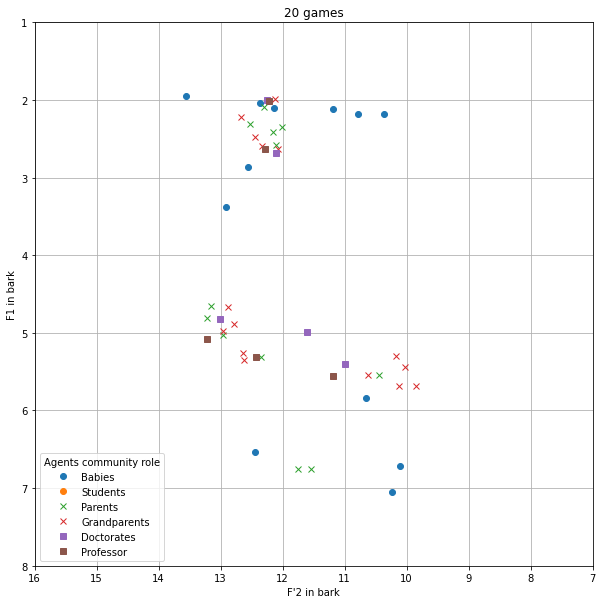

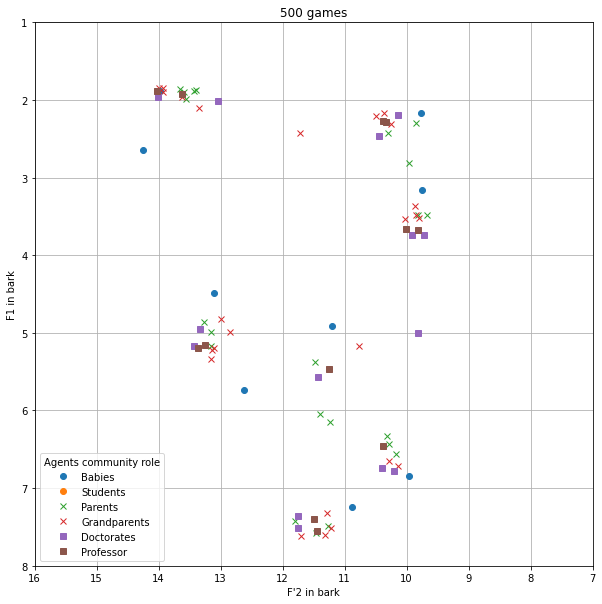

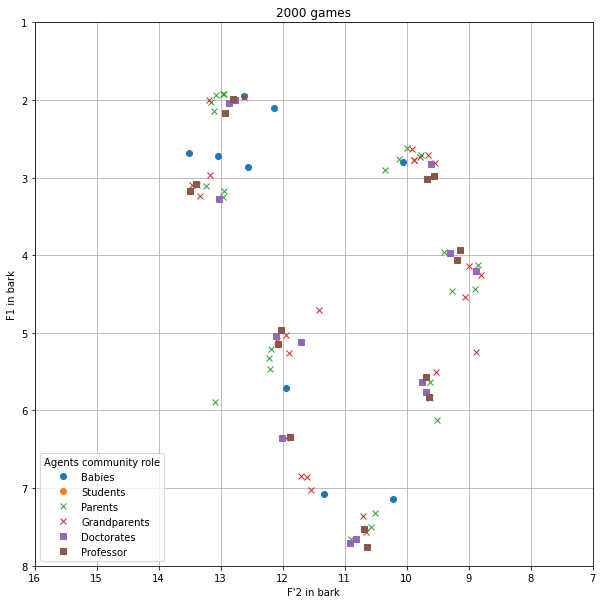

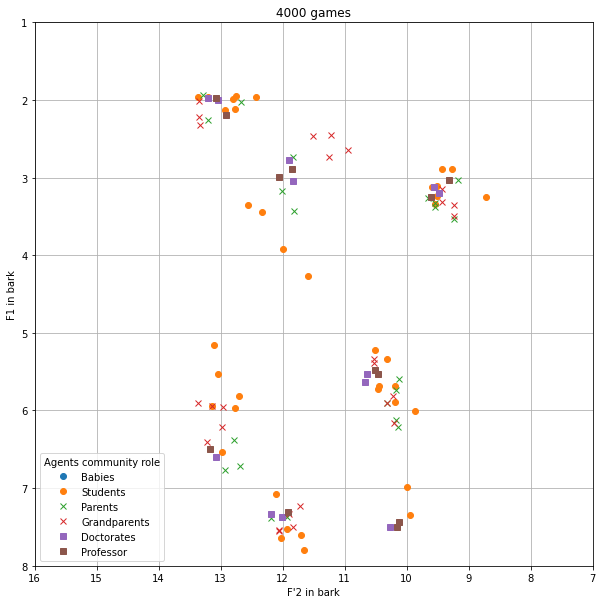

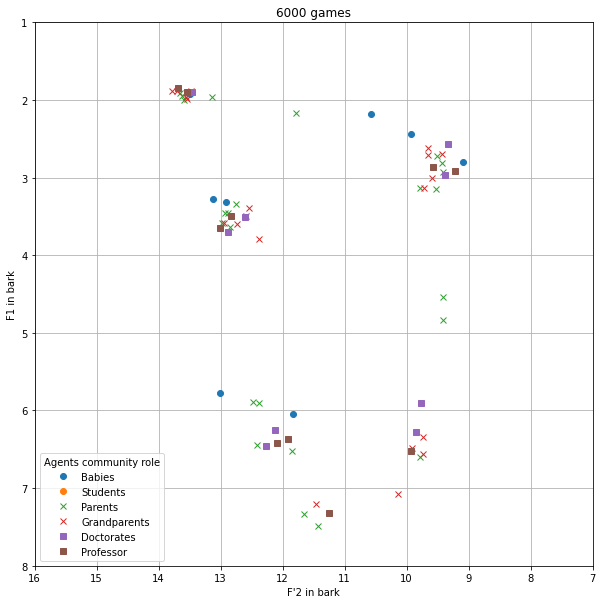

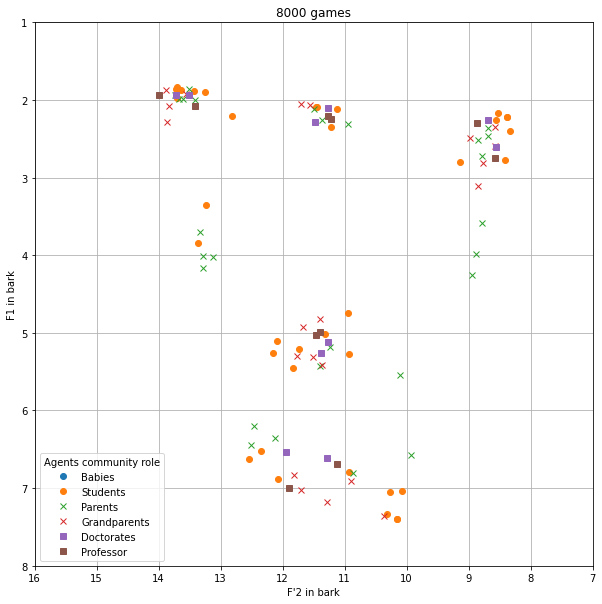

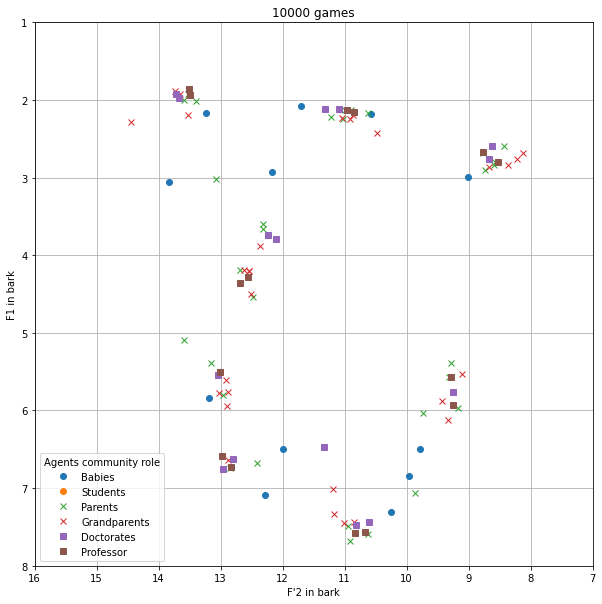

In [10]:
for game_state in game_states:
    game_state.plot();

del game_state;

### Highly educated agents plot

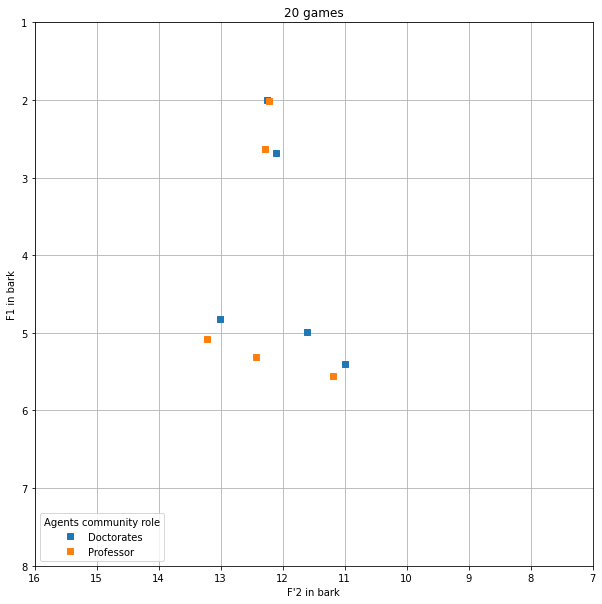

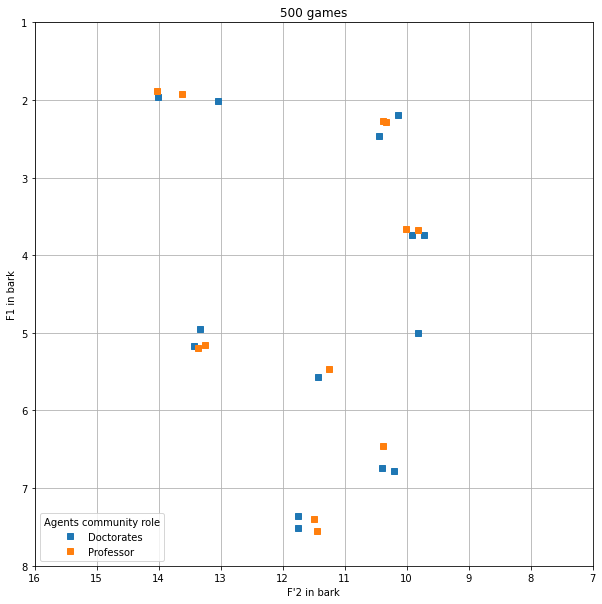

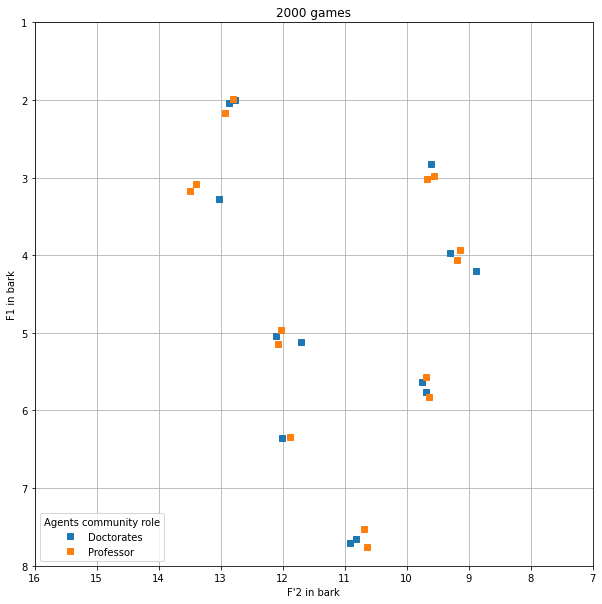

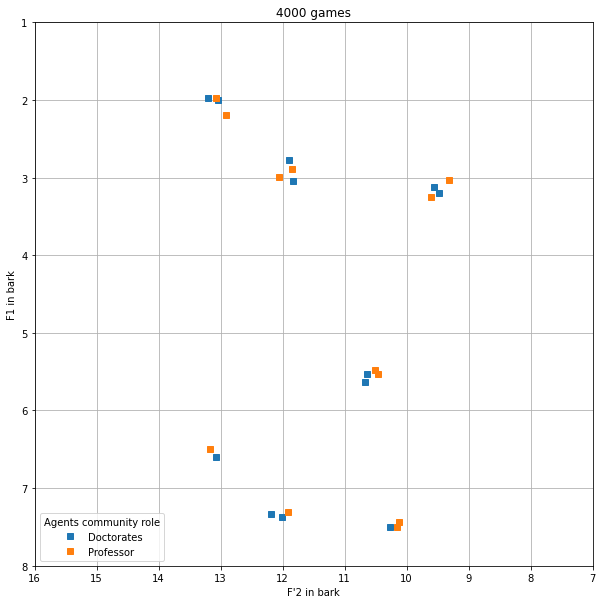

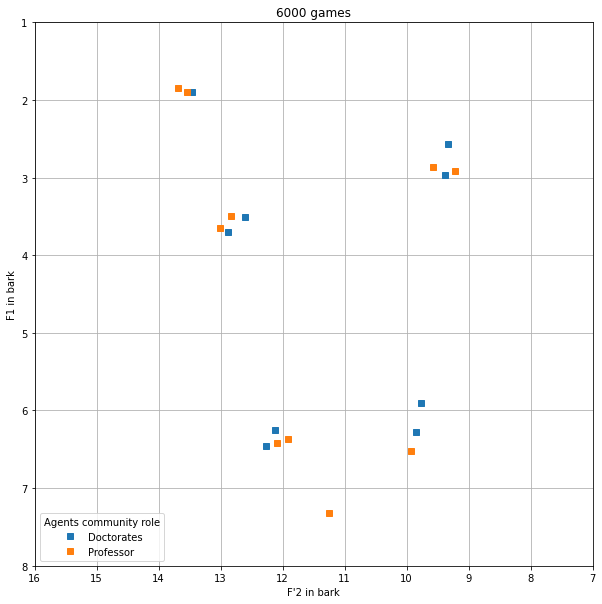

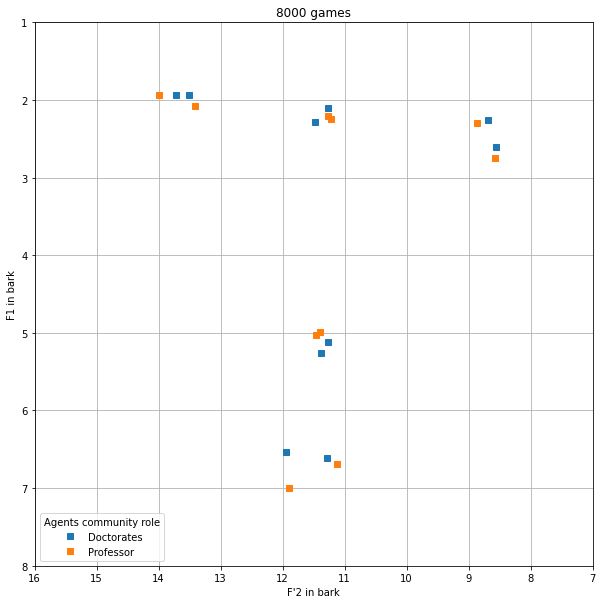

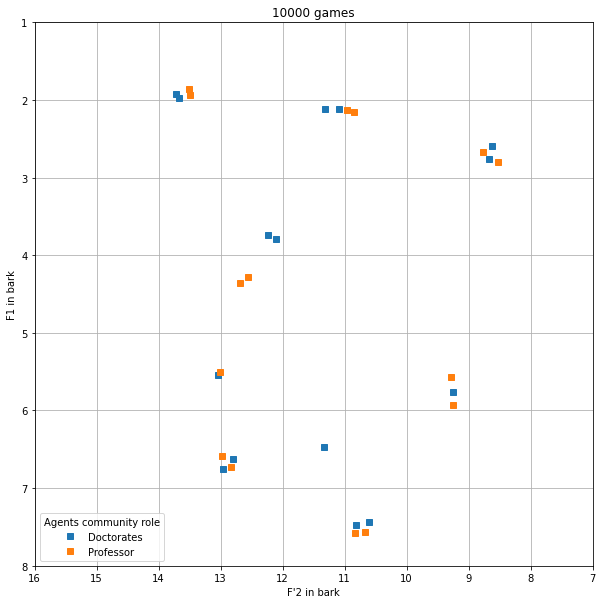

In [11]:
for game_state in game_states:
    game_state.plot_highly_schooled();

del game_state;

### Regular educated agents plot

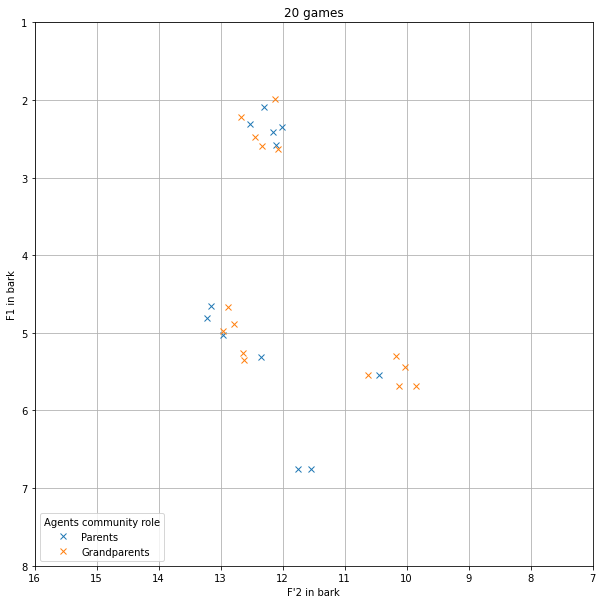

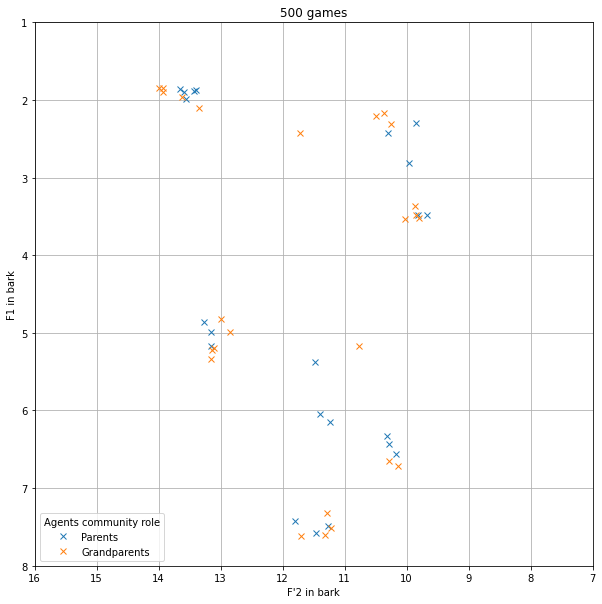

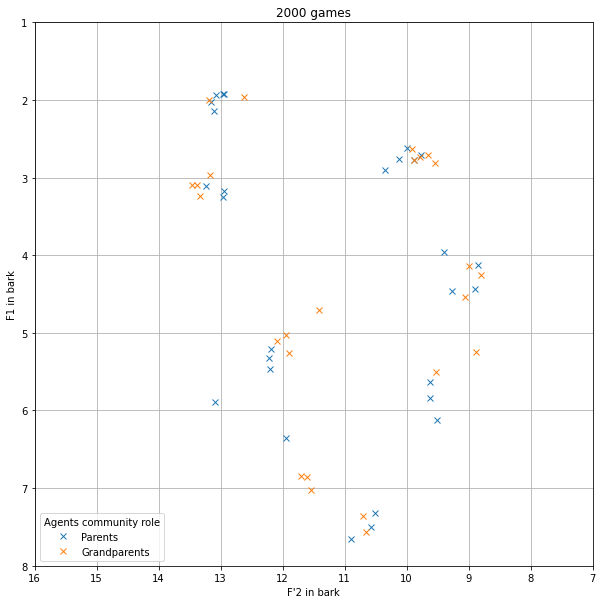

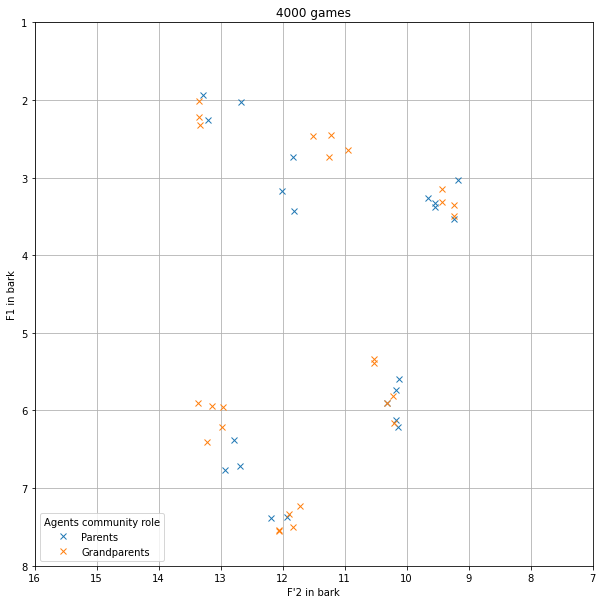

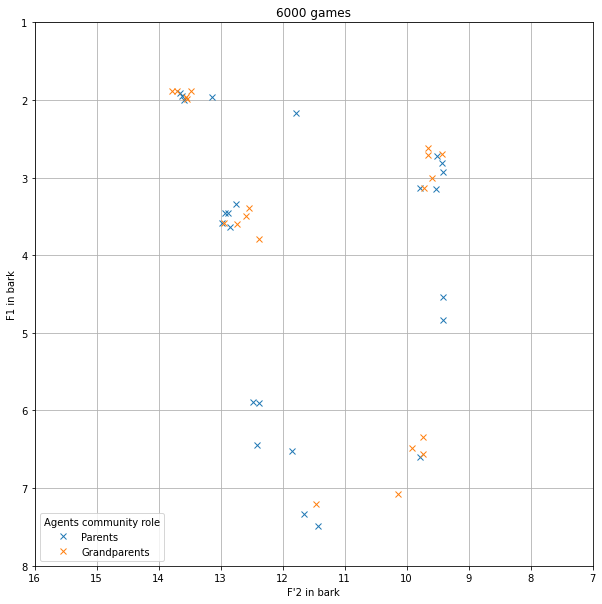

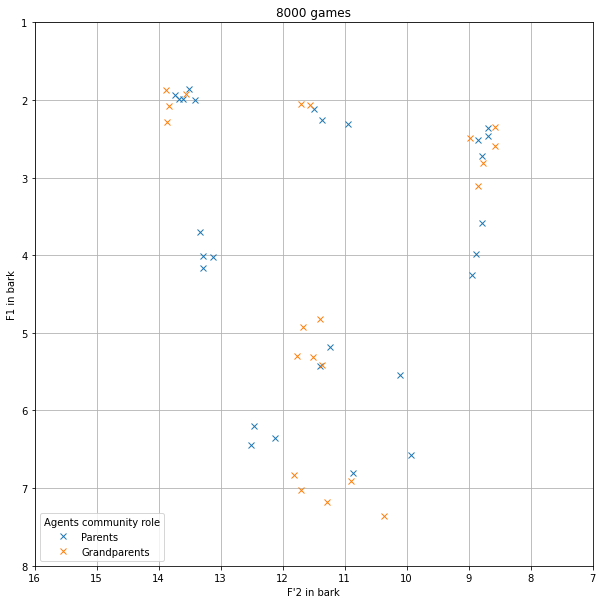

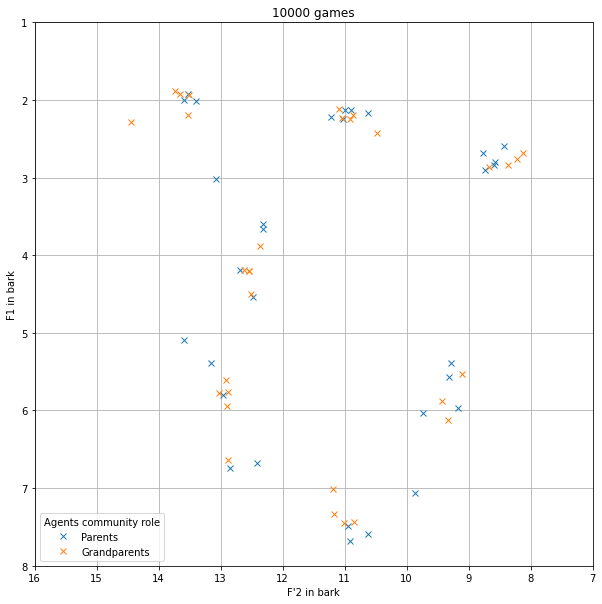

In [12]:
for game_state in game_states:
    game_state.plot_regular_schooled();

del game_state;

<hr>
<hr>

## Adding more statistics

It is handy to evaluate the discussed "highly educated" and "regularly educated" agent groups in a standalone fashion to make comparisons between them.
These extra statistics steps are implemented here.

In [13]:
# Defining child class so that Agent methods are copied
class CommunityStatistics(Statistics):
    
    def extract_agents_with_type_from_community_game_state(self, game_state: CommunityGameState, allowed_roles: list):
        """Returns game state object where only agents of specified type are visible."""
        filtered_state = CommunityGameState(agents=[a for a in game_state.agents if a.community_role in allowed_roles], iteration= game_state.iteration);

        return filtered_state;

    def extract_agents_with_type_from_community_game_states(self, game_states: list, allowed_roles: list):
        """Returns list of game state objects where only agents of specified type are visible."""
        # init filtered states
        filtered_states = [];

        for game_state in game_states:
            filtered_states += [self.extract_agents_with_type_from_community_game_state(game_state, allowed_roles)];

        return filtered_states;

avg and std of success ratio (all agents) [0.6326234147051628, 0.08191065961892185]
avg and std of sound size (all agents) [4.9523809523809526, 0.0]
avg and std of energy (all agents) [4.265557958437448, 0.5002459892303708]

avg and std of success ratio (highly educated agents) [0.7615108698815973, 0.04056211887637523]
avg and std of sound size (highly educated agents) [6.25, 1.25]
avg and std of energy (highly educated agents) [6.9959391624653335, 2.8815413845416393]

avg and std of success ratio (regularly educated agents) [0.7166586871952191, 0.04256750633387274]
avg and std of sound size (regularly educated agents) [5.5, 0.7000000000000002]
avg and std of energy (regularly educated agents) [4.735546103775387, 1.2540351699281533]



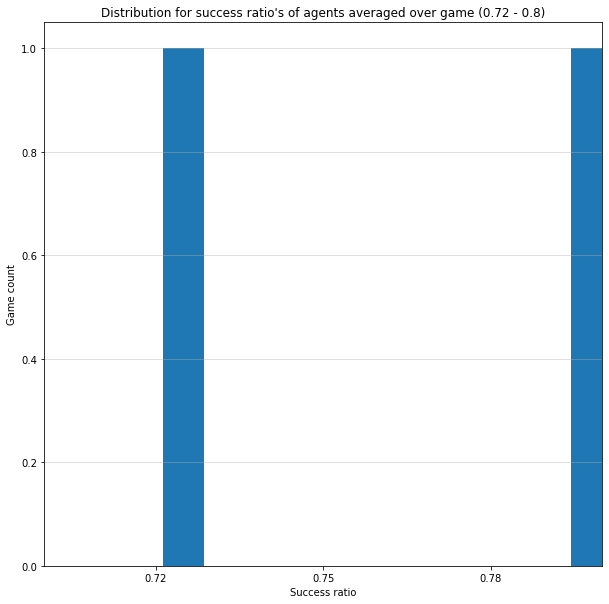

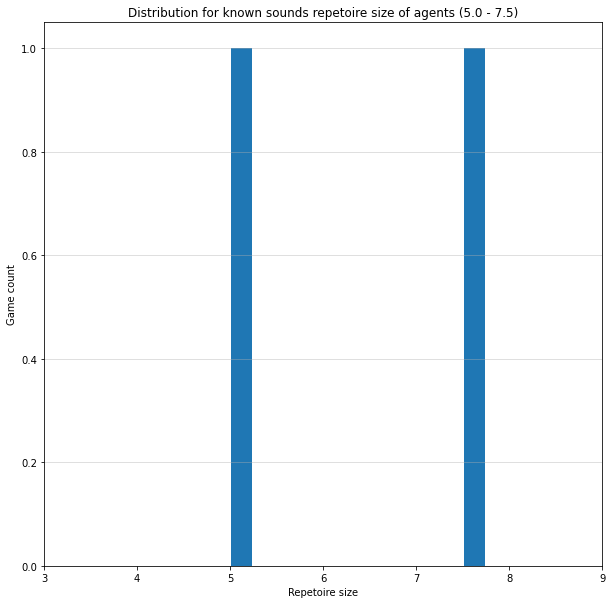

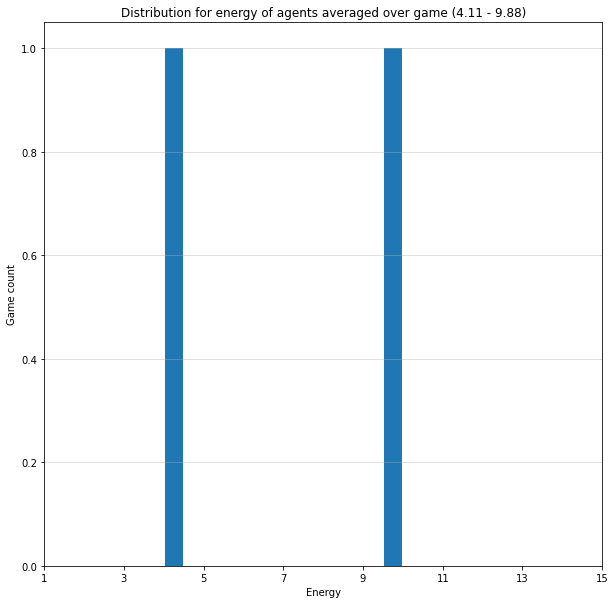

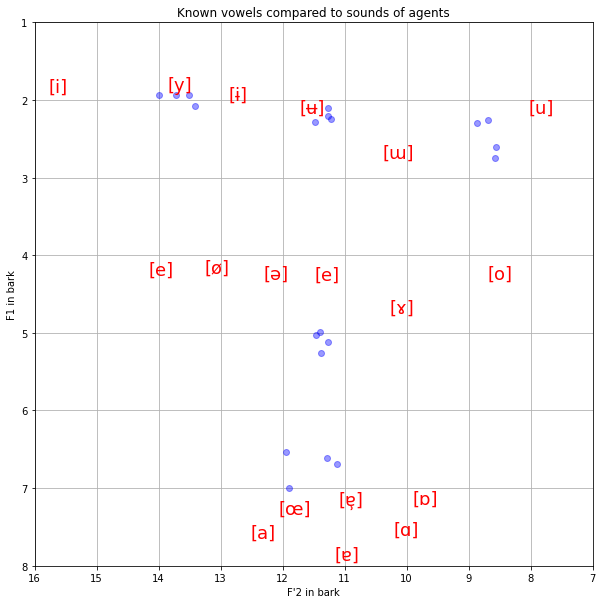

In [14]:
statistics = CommunityStatistics(bark_operator= BarkOperator());

select_game_states = [game_states[-2], game_states[-1]];
select_game_states_high = statistics.extract_agents_with_type_from_community_game_states(select_game_states, [CommunityRole.DOCTORATE, CommunityRole.PROFESSOR]);
select_game_states_regular = statistics.extract_agents_with_type_from_community_game_states(select_game_states, [CommunityRole.PARENT, CommunityRole.GRANDPARENT]);

print("avg and std of success ratio (all agents)", statistics.average_agent_success_ratio(select_game_states));
print("avg and std of sound size (all agents)", statistics.average_agent_sound_size(select_game_states));
print("avg and std of energy (all agents)", statistics.average_agent_energy(select_game_states));
print();

print("avg and std of success ratio (highly educated agents)", statistics.average_agent_success_ratio(select_game_states_high));
print("avg and std of sound size (highly educated agents)", statistics.average_agent_sound_size(select_game_states_high));
print("avg and std of energy (highly educated agents)", statistics.average_agent_energy(select_game_states_high));
print();

print("avg and std of success ratio (regularly educated agents)", statistics.average_agent_success_ratio(select_game_states_regular));
print("avg and std of sound size (regularly educated agents)", statistics.average_agent_sound_size(select_game_states_regular));
print("avg and std of energy (regularly educated agents)", statistics.average_agent_energy(select_game_states_regular));
print();



statistics.plot_agent_success_ratio_distribution(select_game_states_high, left_limit = 0.7, right_limit = 0.8);
statistics.plot_agent_sound_size_distribution(select_game_states_high);
statistics.plot_agent_energy_distribution(select_game_states_high);

statistics.plot_known_vowels_over_sounds(select_game_states_high[-2]);

# Remove unused variables
del statistics;
del game_states;
del select_game_states;
del select_game_states_high;
del select_game_states_regular;